In [2]:
import qcodes as qc
import numpy as np
from time import sleep

import sweep 
from sweep.sweep_load import pload1d
from barreralabdrivers.utils.param_utils import paramp
from cappy.config import coolconfig, datapath
from cappy.balancer import Balancer

from qcodes.validators import Numbers
from qcodes.parameters import Parameter, ScaledParameter 
import datetime

In [2]:
# instrument connections 
qc.Instrument.close_all()   # in case of existing connecitons
container = qc.Station(config_file=str(coolconfig))

acdac = container.load_instrument("acdac")
yoko = container.load_instrument("yoko")
keithley = container.load_instrument("keithley")
li1 = container.load_instrument("lockin1")
li2 = container.load_instrument("lockin2")

print(100 * "-")
print(f"{datetime.datetime.now().strftime('%c')}")
# ppms = container.load_instrument("ppms") # update PPMS PC ethernet IP address to 169.254.x.x 

Connected to: BARRERA ACDAC02 (serial:AD9106, firmware:2.00) in 3.34s
Connected to: YOKOGAWA 765611 (serial:90ZC43353, firmware:1.10) in 0.02s
Connected to: KEITHLEY INSTRUMENTS DMM6500 (serial:04608216, firmware:1.7.12b) in 0.01s
Connected to: Stanford_Research_Systems SR865A (serial:005296, firmware:V1.51) in 0.11s
Connected to: Stanford_Research_Systems SR860 (serial:005276, firmware:V1.51) in 0.09s
----------------------------------------------------------------------------------------------------
Fri Nov 29 10:46:41 2024


In [3]:
acdac.ch4.voltage(400)

In [5]:
acdac.ch1.voltage(10)

In [6]:
# TODO: aliases for parameters. Update labels to reflect physical quantities for following cell

vg = yoko.channel2.voltage
vg.label = "Vg"
neg_val = Numbers(min_value=-2, max_value=0.001)
vg.add_validator(neg_val)                       # never allow positive values on Vg 


vdd = yoko.channel1.voltage 
vdd.label = "Vdd"

vds = keithley.amplitude
vds.label = "Vds"

V1 = acdac.ch1
V2 = acdac.ch2

Gout = li1
Vtherm = li2.X

# getting temperature from BNC outs on PPMS, reading on lockin Analog in. 
temptemp = ScaledParameter(Gout.aux_in0, gain = 40, name="ppms_temperature", label="temp", unit="K")


indep_params = [vg]
dep_params = [vds, Gout.R, Gout.P]

In [6]:
temptemp()

2.4122142791599996

In [10]:
# class LI_Temp():
#     def __init__(self, lockin):
#         self.full_name = "temp"
#         self._voltage = lockin.X

#     def get(self):
#         TODO: update with getting function
#         return self._voltage()
    
#     def set(self, val):
#         # TODO: update with setting function
    
#     __call__ = get

# therm = LI_Temp(li1)
# print(therm())

In [11]:
# V1.voltage(0)
# V2.voltage(0)
# acdac.ch4.voltage(400)

In [7]:
# measurement config for analysis 
mc = {}
for param in indep_params + dep_params:
    mc[param.full_name] = param.label

s = sweep.Station(basedir=datapath, measurement_config=mc)
for param in indep_params + dep_params:
    s.fp(param)

s.add_comment("Vg sweep: amp fixed t2")

In [13]:
# instrument setup

In [9]:
vdd(0.1)

In [15]:
# paramp(vg), paramp(vdd)

In [10]:
# TODO: add parameters to live plot here 

for dep in dep_params:
    s.plot(vg, dep)

In [13]:
s.reset()

2024-11-29 10:55:00,571 [INFO] Starting sweep with ID 32
2024-11-29 10:55:00,571 [INFO] Minimum duration 0h 0m 40s


  0%|          | 0/100 [00:00<?, ?it/s]

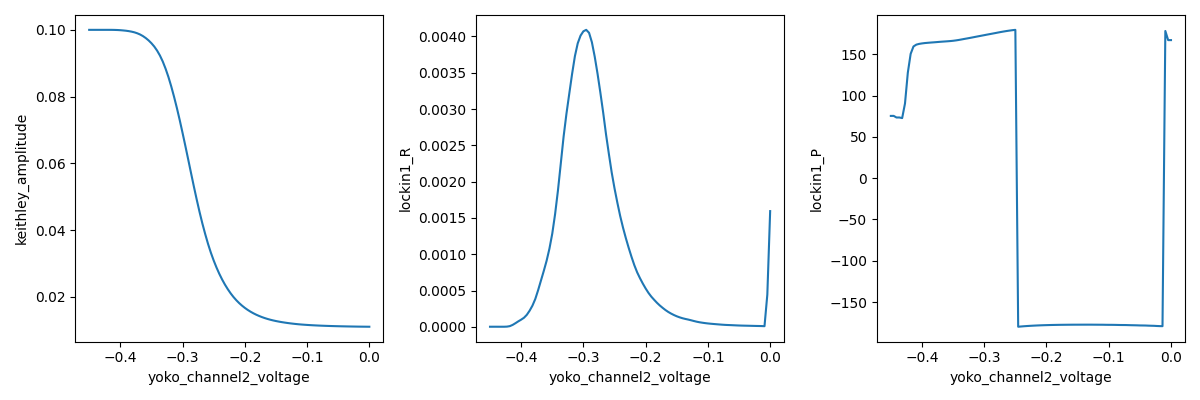

2024-11-29 10:55:45,805 [INFO] Completed in 0h 0m 44s
2024-11-29 10:55:45,805 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data\32\data.tsv.gz


In [14]:
# Run experiment 
START = 0
STOP = -0.45
SAMPLES = 100
INT_TIME = 0.4

# s.watch(delay = INT_TIME, max_duration=10)
setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(vg, setpoints, delay=INT_TIME)

In [15]:
paramp(vg), paramp(vdd)

(None, None)

In [19]:
V1.voltage(0)

In [20]:
acdac.print_readable_snapshot()

acdac:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': 'BARRERA', 'model': 'ACDAC02', 'serial': 'AD9106', ...
display_mode :	REMOTE 
 rror        :	0 - No Error
frequency    :	50003 (Hz)
timeout      :	5 (s)
acdac_ch1:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch2:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch3:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch4:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	400 (mV)


In [17]:
V1.voltage(10)

In [16]:
vdd(0.1)

2024-11-29 14:12:26,416 [INFO] Starting sweep with ID 33
2024-11-29 14:12:26,416 [INFO] Minimum duration 0h 0m 40s


  0%|          | 0/100 [00:00<?, ?it/s]

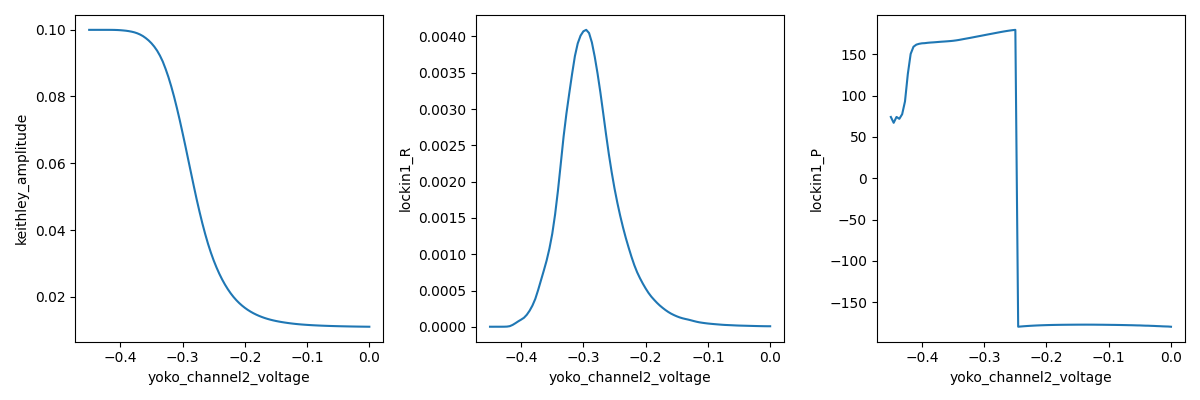

2024-11-29 14:13:11,775 [INFO] Completed in 0h 0m 45s
2024-11-29 14:13:11,775 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data\33\data.tsv.gz


In [18]:
# Run experiment 
START = 0
STOP = -0.450
SAMPLES = 100
INT_TIME = 0.4

# s.watch(delay = INT_TIME, max_duration=10)
setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(vg, setpoints, delay=INT_TIME)

In [25]:
temptemp()

299.367027284

In [19]:
# Look at result metadate for verification 
from sweep.sweep_load import pload1d

data = pload1d(datapath, 33)
Gout_R = data[Gout.R.full_name]
Vgs = data[vg.full_name]

dc_bias = Vgs[np.argmax(Gout_R)]
print(dc_bias, np.max(Gout_R))

-0.29546 0.0040906202048


In [20]:
paramp(vg, dc_bias)

In [27]:
## Balancing arguments
FREQ = 50000
DELTA = (180, 180)
INITIAL = (10, 10)
Cstand = 1  # pF
DRIVE = 10

In [22]:
balancer = Balancer(acdac.ch1, acdac.ch4, acdac.ch2, Gout, acdac.frequency) # ch1 = control, ch4 = reference, ch2 = drive

In [28]:
balancer.excite(DRIVE, 400, FREQ)

In [30]:
null_voltages = balancer.balance(INITIAL, DELTA, null=True)
c_meas = balancer.calculate_capacitance(Cstand)
print(f"null voltages = {null_voltages}")
print(f"Balance Point Capacitance: {c_meas} nF")

Kr1, Kr2 = (np.float64(-0.00032935891394444446), np.float64(-0.0038869640169055556))
Kc1, Kc2 = (np.float64(0.003886006581722222), np.float64(-0.00032723680002777776))
P = 0.007084833550070754
null voltages = (np.float64(53.81480350478809), np.float64(3.461965678297095))
Balance Point Capacitance: 5.3814803504788085 nF


In [31]:
class Capacitance():
    def __init__(self, calc, balance, init = INITIAL, delta = DELTA, Cstand = Cstand):
        self.balance = balance
        self.calc = calc
        self.init = init 
        self.delta = delta
        self.Cstand = Cstand
        self.full_name = "capacitance"

    def get(self):
        self.balance(self.init, self.delta, null=True)
        c_meas = self.calc(self.Cstand)
        return float(c_meas)
    
    __call__ = get

cap = Capacitance(balancer.calculate_capacitance, balancer.balance)

In [46]:
l = cap()

Kr1, Kr2 = (np.float64(-1.6606655761111106e-05), np.float64(-4.536761808722223e-05))
Kc1, Kc2 = (np.float64(4.776296818333334e-05), np.float64(-2.0153004401111113e-05))
P = 0.13378579356857254


In [47]:
l

3.711159728254378

In [48]:
acdac.print_readable_snapshot()

acdac:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': 'BARRERA', 'model': 'ACDAC02', 'serial': 'AD9106', ...
display_mode :	REMOTE 
 rror        :	0 - No Error
frequency    :	50000 (Hz)
timeout      :	5 (s)
acdac_ch1:
	parameter value
--------------------------------------------------------------------------------
phase   :	-167.96 (deg)
voltage :	379.47 (mV)
acdac_ch2:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	100 (mV)
acdac_ch3:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch4:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	400 (mV)


In [ ]:
# sets = np.linspace(0, 400, 40)
# curr_min = np.inf 
# for setx in sets:
#     acdac.ch2.voltage(setx)
#     sleep(0.5)
#     curr_min = min(curr_min, Gout.P())

# print(curr_min)

In [49]:
paramp(vdd)
paramp(vg)

# November 27th 

## Getting Frequency analysis on amp, balancing software

# Bode Sweep. Freq 0-2.5 MHz

In [42]:
# V2.voltage(0)
# V1.voltage(10)
# V1.phase(0)

exps = np.linspace(1.5, 6.4, 600)
freqs = 10**exps

In [ ]:
# measurement config for analysis 
ips = [acdac.frequency]

dps = [li1.R, li1.P]
mc = {}
for param in ips + dps:
    mc[param.full_name] = param.label

sf = sweep.Station(basedir=datapath, measurement_config=mc)
for param in ips + dps:
    sf.fp(param)

sf.add_comment("Bode Sweep: Frequency 0-2.5 MHz")

In [35]:
for dp in dps:
    sf.plot(acdac.frequency, dp)

In [36]:
V1.voltage(100)
V2.voltage(0)

In [44]:
sf.reset()

## Sweeping FREQ on ch 1 and ch 2

2024-11-29 14:33:43,101 [INFO] Starting sweep with ID 37
2024-11-29 14:33:43,101 [INFO] Minimum duration 0h 15m 0s


  0%|          | 0/600 [00:00<?, ?it/s]

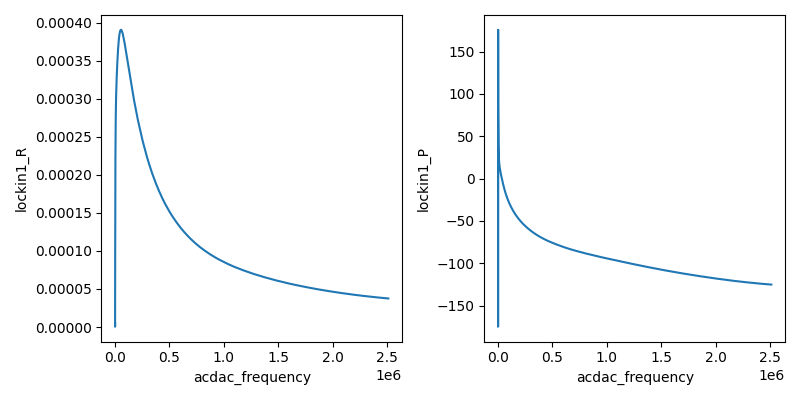

2024-11-29 14:49:10,176 [INFO] Completed in 0h 15m 26s
2024-11-29 14:49:10,176 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data\37\data.tsv.gz
2024-11-29 14:49:10,205 [INFO] Starting sweep with ID 38
2024-11-29 14:49:10,205 [INFO] Minimum duration 0h 15m 0s


  0%|          | 0/600 [00:00<?, ?it/s]

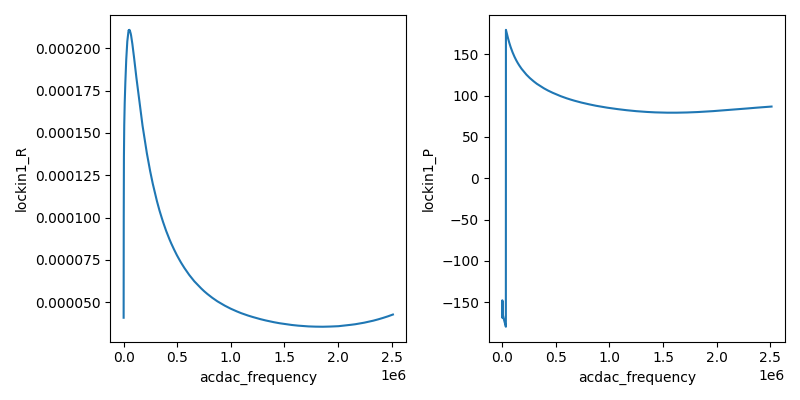

2024-11-29 15:04:37,394 [INFO] Completed in 0h 15m 26s
2024-11-29 15:04:37,394 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data\38\data.tsv.gz


In [45]:
vg(dc_bias) #biasing hemt with V_bias from earlier in notebook
vdd(0.1)# setting vdd to 100mv

#FIRST sweep with ch.1 = 100mV (100x attenuation) which goes to 1pF capacitor
V1.voltage(100)
V2.voltage(0)
sf.sweep(acdac.frequency, setpoints=freqs, delay=1.5)

#Second Sweep with ch2 = 10mV (no attenuation) which goes to Cref

V1.voltage(0)
V2.voltage(10)
sf.sweep(acdac.frequency, setpoints=freqs, delay=1.5)

In [47]:
#loading data from data runs 37, 38
import matplotlib.pyplot as plt
d = pload1d(datapath, 37)
posD = d[li1.P.full_name] + (360 * (d[li1.P.full_name] < 0))

plt.plot(freqs, posD)
plt.show()

# Balancing across Frequency

In [119]:
exps = np.linspace(2.5, 6.4, 200)
freqs = 10**exps
freqs

array([3.16227766e+02, 3.30824748e+02, 3.46095522e+02, 3.62071190e+02,
       3.78784291e+02, 3.96268864e+02, 4.14560519e+02, 4.33696512e+02,
       4.53715817e+02, 4.74659207e+02, 4.96569338e+02, 5.19490834e+02,
       5.43470380e+02, 5.68556815e+02, 5.94801232e+02, 6.22257084e+02,
       6.50980290e+02, 6.81029350e+02, 7.12465467e+02, 7.45352666e+02,
       7.79757928e+02, 8.15751327e+02, 8.53406171e+02, 8.92799151e+02,
       9.34010501e+02, 9.77124154e+02, 1.02222792e+03, 1.06941366e+03,
       1.11877749e+03, 1.17041993e+03, 1.22444617e+03, 1.28096625e+03,
       1.34009528e+03, 1.40195369e+03, 1.46666747e+03, 1.53436841e+03,
       1.60519441e+03, 1.67928972e+03, 1.75680524e+03, 1.83789886e+03,
       1.92273574e+03, 2.01148866e+03, 2.10433839e+03, 2.20147404e+03,
       2.30309344e+03, 2.40940356e+03, 2.52062093e+03, 2.63697206e+03,
       2.75869392e+03, 2.88603443e+03, 3.01925294e+03, 3.15862077e+03,
       3.30442179e+03, 3.45695294e+03, 3.61652488e+03, 3.78346262e+03,
      

In [109]:
acdac.ch2.voltage(10)

In [112]:
balancer = Balancer(acdac.ch1, acdac.ch4, acdac.ch2, Gout, acdac.frequency)

## Balancing arguments
FREQ = 50000
DELTA = (180, 180)
INITIAL = (10, 10)
Cstand = 1  # pF
DRIVE = 40

VX = 0 
VY = 0

def rebalance(INITIAL, DELTA, null=True):
    vx, vy = balancer.balance(INITIAL, DELTA, null=True)
    global VX
    global VY
    VX = vx 
    VY = vy

class Capacitance():
    def __init__(self):
        self.full_name = "capacitance"

    def __call__(self):
        return balancer.calculate_capacitance(Cstand)
    
class Conductance():
    def __init__(self):
        self.full_name = "conductance"

    def __call__(self):
         if balancer._balanced:
            return (
                np.abs(2 * np.pi * balancer.frequerncy() * balancer.V0y * Cstand / balancer.drive_voltage)
            )    

class Vx():
    def __init__(self):
        self.full_name = "in-phase nulling voltage"

    def __call__(self):
        return VX 
    
class Vy():
    def __init__(self):
        self.full_name = "out-of-phase nulling voltage"

    def __call__(self):
        return VY 

In [114]:
balancer.excite(DRIVE, 400, FREQ)

In [115]:
rebalance(INITIAL,DELTA)

Kr1, Kr2 = (np.float64(-0.00032689842755555596), np.float64(-0.0038876671169555555))
Kc1, Kc2 = (np.float64(0.0038890880710555553), np.float64(-0.00032538093566666666))
P = 0.006985918152296835


In [116]:
cap = Capacitance()
cond = Conductance()
vx = Vx()
vy = Vy()

In [118]:
cap()

np.float64(5.323785126932045)

In [93]:
# TODO: add mc
ip = acdac.frequency
dps = [cap, cond, vx, vy]

sw = sweep.Station(basedir=datapath)
for param in dps:
    sw.fp(param)

sw.register_run_before(rebalance, [INITIAL, DELTA, False])

In [94]:
for dp in dps:
    sw.plot(acdac.frequency, dp)

sw.add_comment("Bode Sweep: Frequency 0-2.51MHz")

In [95]:
balancer.drive_voltage

0

In [96]:
#getting weird behaviour on 1pF capacitor just checking to see what's up
acdac.frequency(2000)

#turns out that the impedance on 1pF is too great to balance at 1kHz

2024-11-29 15:35:57,270 [INFO] Starting sweep with ID 48
2024-11-29 15:35:57,271 [INFO] Minimum duration 0h 5m 0s


  0%|          | 0/200 [00:00<?, ?it/s]

Kr1, Kr2 = (np.float64(0.0001848246029444443), np.float64(5.817843583888891e-05))
Kc1, Kc2 = (np.float64(-5.897584033333332e-05), np.float64(0.00018449686146666672))
P = 0.9085782079274279
Kr1, Kr2 = (np.float64(0.00019999263005555563), np.float64(6.403186285555557e-05))
Kc1, Kc2 = (np.float64(-6.36196798888888e-05), np.float64(0.00019981465203888895))
P = 0.9074901042601606
Kr1, Kr2 = (np.float64(0.00020728330127777782), np.float64(6.783735041111115e-05))
Kc1, Kc2 = (np.float64(-6.494608694444437e-05), np.float64(0.0002085109978777778))
P = 0.9074935277540147
Kr1, Kr2 = (np.float64(0.00022481706566666653), np.float64(7.11564401444445e-05))
Kc1, Kc2 = (np.float64(-6.937100094444454e-05), np.float64(0.00022282090665000002))
P = 0.910300176482502
Kr1, Kr2 = (np.float64(0.00023854461483333326), np.float64(7.63940382777777e-05))
Kc1, Kc2 = (np.float64(-7.531941972222218e-05), np.float64(0.00023910017466111108))
P = 0.9083619465285631
Kr1, Kr2 = (np.float64(0.0002560507305555557), np.float6

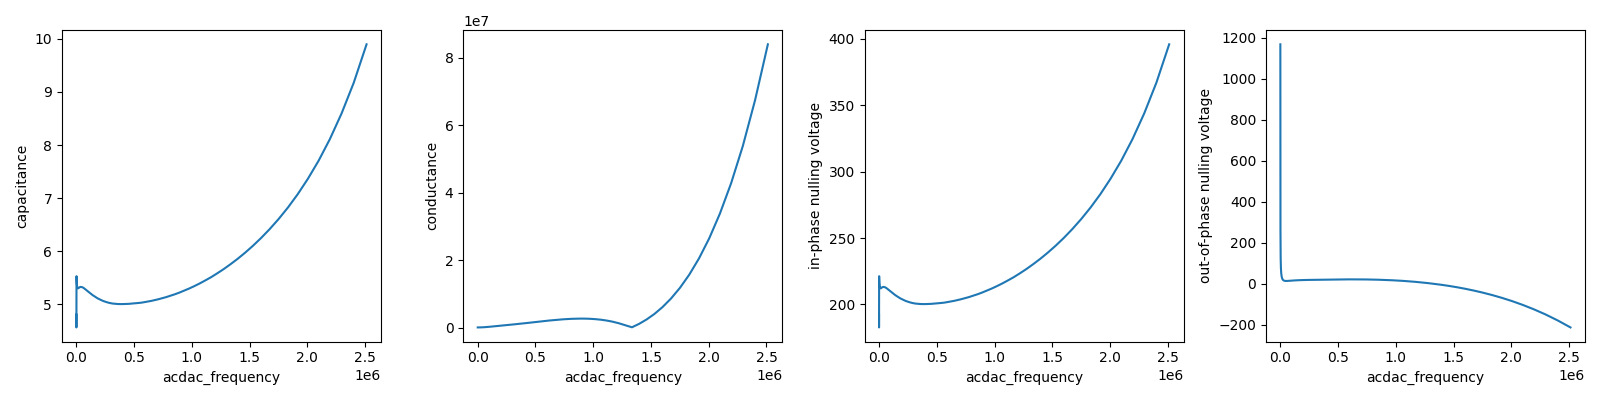

2024-11-29 16:01:44,238 [INFO] Completed in 0h 25m 46s
2024-11-29 16:01:44,238 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data\48\data.tsv.gz


In [120]:
sw.sweep(acdac.frequency, setpoints=freqs, delay=1.5)

# Noise Floor

In [125]:
acdac.frequency(50000)


from typing import overload, Union

class BalancingScale:
    def __init__(self):
        self.full_name = "balancing_scale"
        self.scaling = 1

    @overload
    def __call__(self) -> float:
        ...

    @overload
    def __call__(self, val: float) -> None:
        ...

    def __call__(self, val: Union[float, None] = None) -> Union[float, None]:
        if val is None:
            # Getter logic
            return self.scaling
        else:
            # Setter logic
            self.scaling = val

    def __mul__(self, other):
        self.scaling *= other
        return self
    
    def __rmul__(self, other):
        self.scaling *= other
        return self



In [143]:
scaling = BalancingScale()
DDELTA = np.array([240,240])
DDRIVE = 70

indep_params = scaling
dep_params = [cap, cond, vx, vy]

sw = sweep.Station(basedir=datapath)
sw.reset()
sw.reset_plots()
for param in dep_params:
    sw.fp(param)

def update_constants():
    balancer.excite(DDRIVE * scaling(), 400, FREQ)
    print(DDRIVE * scaling())

    vx, vy =balancer.balance(INITIAL, DDELTA * scaling(), null = True)
    global VX
    global VY
    VX = vx 
    VY = vy

sw.register_run_before(update_constants,[])





In [144]:
for dparam in dep_params:
    sw.plot(DDRIVE*scaling, dparam)

sw.add_comment("Excitation Sweep: 100mV -> 10mV")

2024-11-29 17:34:01,318 [INFO] Starting sweep with ID 57
2024-11-29 17:34:01,318 [INFO] Minimum duration 0h 0m 30s


  0%|          | 0/30 [00:00<?, ?it/s]

70.0
Kr1, Kr2 = (np.float64(-0.000327720772499999), np.float64(-0.0038883771291250003))
Kc1, Kc2 = (np.float64(0.0038875922958750008), np.float64(-0.00032532158607499994))
P = 0.007003505490085241
67.82758620689656
Kr1, Kr2 = (np.float64(-0.0003260320699881372), np.float64(-0.0038904138971396795))
Kc1, Kc2 = (np.float64(0.003890323163561684), np.float64(-0.0003265073896075029))
P = 0.006984381102774879
65.6551724137931
Kr1, Kr2 = (np.float64(-0.00032744578799019577), np.float64(-0.0038846200965716913))
Kc1, Kc2 = (np.float64(0.003883682220179228), np.float64(-0.0003255064239407169))
P = 0.00701534879296018
63.48275862068966
Kr1, Kr2 = (np.float64(-0.0003275763195025337), np.float64(-0.003887385078133713))
Kc1, Kc2 = (np.float64(0.0038863169600301018), np.float64(-0.0003259824996444867))
P = 0.007018626078382691
61.310344827586206
Kr1, Kr2 = (np.float64(-0.0003284111369914695), np.float64(-0.003889448826141732))
Kc1, Kc2 = (np.float64(0.003888355875892389), np.float64(-0.000326345171782

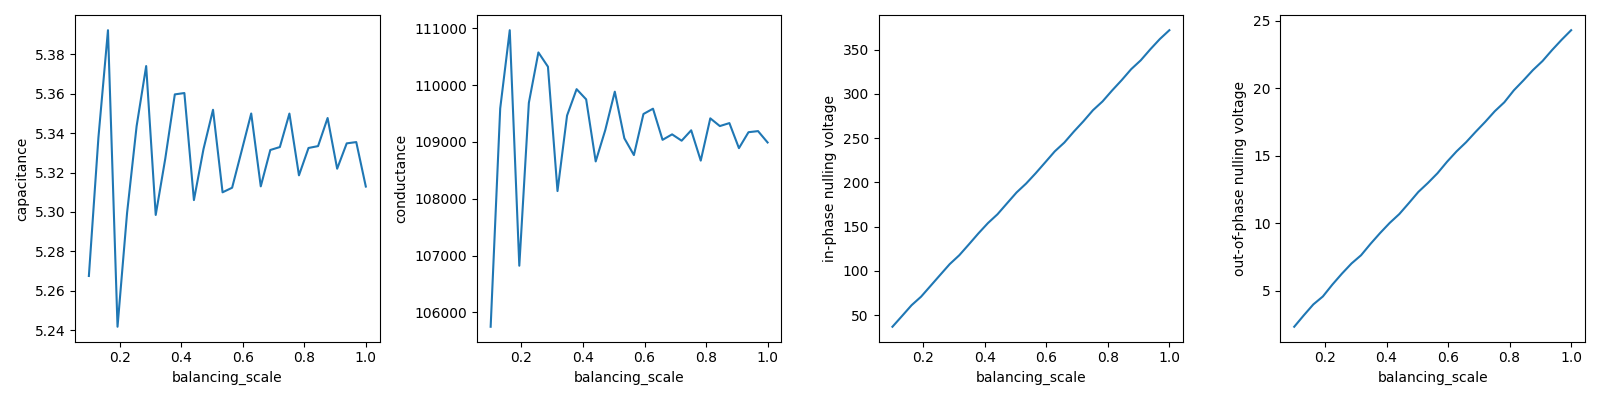

2024-11-29 17:37:44,795 [INFO] Completed in 0h 3m 43s
2024-11-29 17:37:44,795 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data\57\data.tsv.gz


In [145]:
sw.reset()
sw.sweep(scaling, setpoints = np.linspace(1,0.1, 30), delay = 1)

2024-11-29 17:40:31,021 [INFO] Starting sweep with ID 59
2024-11-29 17:40:31,022 [INFO] Minimum duration 0h 0m 30s


  0%|          | 0/30 [00:00<?, ?it/s]

70.0
Kr1, Kr2 = (np.float64(-3.123113858333332e-05), np.float64(-0.00038287424028333333))
Kc1, Kc2 = (np.float64(0.00038392807556249996), np.float64(-3.225751659875e-05))
P = 0.006806854079575433
67.82758620689656
Kr1, Kr2 = (np.float64(-3.2755114021352344e-05), np.float64(-0.00038405425365080066))
Kc1, Kc2 = (np.float64(0.00038238956802253847), np.float64(-3.2189035471782324e-05))
P = 0.007128228731709728
65.6551724137931
Kr1, Kr2 = (np.float64(-3.180433647212002e-05), np.float64(-0.0003836578082009804))
Kc1, Kc2 = (np.float64(0.00038243891809022675), np.float64(-3.2583646527313114e-05))
P = 0.007013314719152366
63.48275862068966
Kr1, Kr2 = (np.float64(-3.20799092553866e-05), np.float64(-0.00038165150406384665))
Kc1, Kc2 = (np.float64(0.0003835259838727819), np.float64(-3.094289758295311e-05))
P = 0.006735922304051794
61.310344827586206
Kr1, Kr2 = (np.float64(-3.2422188671259784e-05), np.float64(-0.00038331149370674216))
Kc1, Kc2 = (np.float64(0.00038232381575180454), np.float64(-3.21

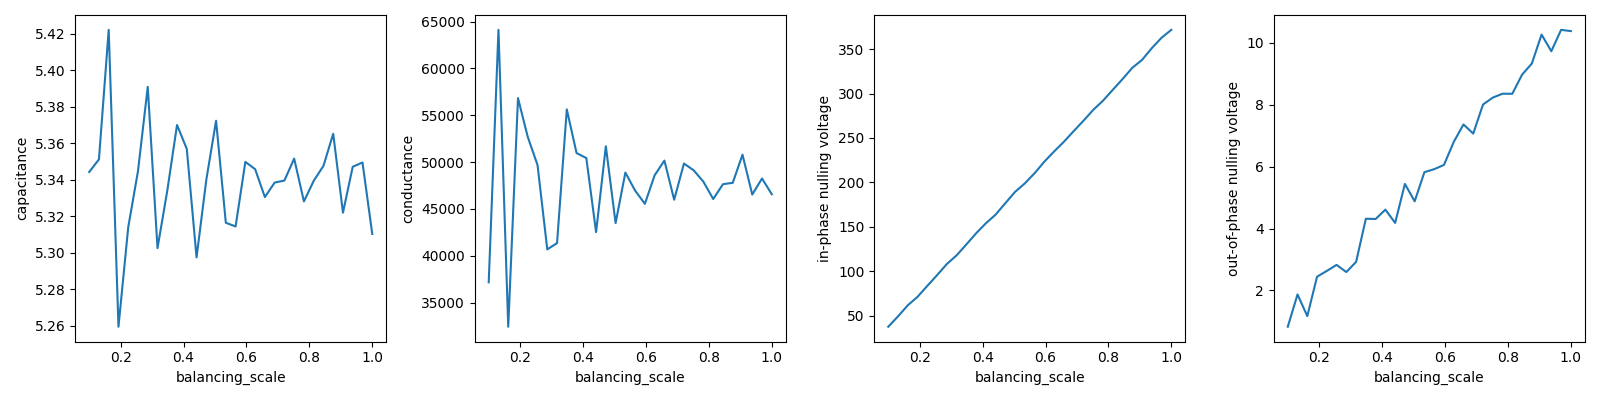

2024-11-29 17:44:13,795 [INFO] Completed in 0h 3m 42s
2024-11-29 17:44:13,795 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data\59\data.tsv.gz


In [147]:
## FINDING NOISE FLOOR WITH 1000x attenuators on 1pf 10x on cref
sw.sweep(scaling, setpoints = np.linspace(1,0.1, 30), delay = 1)

In [148]:
paramp(vg), paramp(vdd)

(None, None)

In [2]:
from C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\src\cappy\opener.py import Opener

opened = Opener(file_path, 57)
data = opened.getdata()

plt.plot(data['balancing_scale'], data['capacitance'])
plt.show()

SyntaxError: invalid syntax (2184852084.py, line 1)